In [ ]:
#########################
##  Transfer Learning  ##
#########################

# Importing Library for Preprocessing 
import random 
import numpy as np
import matplotlib.pyplot as plt 
import torch 
import torchvision.transforms as transforms
import torch.utils.data as data 
import zipfile
import os 
import seaborn as sns
from tqdm import tqdm
import shutil
from PIL import Image
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split 
from tensorflow.keras import layers, models

In [25]:
# Extract The data From The zip File 

def extract_data(zip_path,extract_to):
  
    os.makedirs(extract_to, exist_ok=True)

  
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted {len(zip_ref.namelist())} files to {extract_to}") 

# file paths
zip_file_path = r"D:\UNI (2)\Brain Tumor Project\archive.zip"
output_directory = r"D:\UNI (2)\Brain Tumor Project"


extract_data(zip_file_path, output_directory)  

Extracted 800 files to D:\UNI (2)\Brain Tumor Project


In [26]:
# Set up the path for your dataset
dataset_path = r"D:\UNI (2)\Brain Tumor Project\Dataset"
healthy_path = os.path.join(dataset_path, 'healthy')
tumor_path = os.path.join(dataset_path, 'tumor')

# Constants
img_size = 128  # All models use 224x224 images
input_shape = (img_size, img_size, 3)

# Helper functions for loading and preprocessing the dataset
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = tf.keras.preprocessing.image.load_img(os.path.join(folder, filename), target_size=(img_size, img_size))
        if img is not None:
            images.append(tf.keras.preprocessing.image.img_to_array(img))
    return images

# Load images for healthy and tumor categories
healthy_images = load_images_from_folder(healthy_path)
tumor_images = load_images_from_folder(tumor_path)

# Labels for the dataset
healthy_labels = [0] * len(healthy_images)
tumor_labels = [1] * len(tumor_images)

# Combine and reshape
X = np.array(healthy_images + tumor_images)
y = np.array(healthy_labels + tumor_labels)

# Normalize the images
X = X / 255.0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\Dell\AppData\Local\Temp\ipykernel_3480\1827747244.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette=custom_colors)


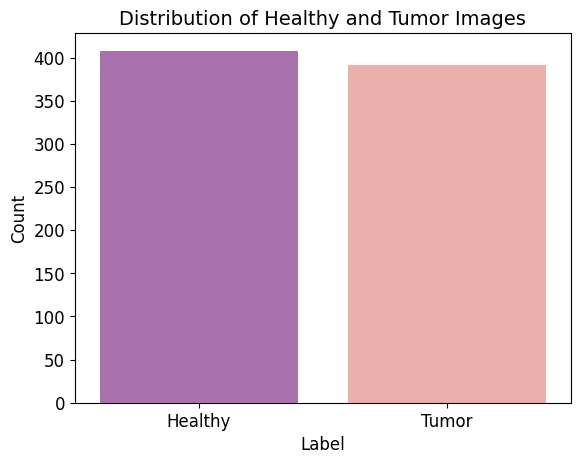

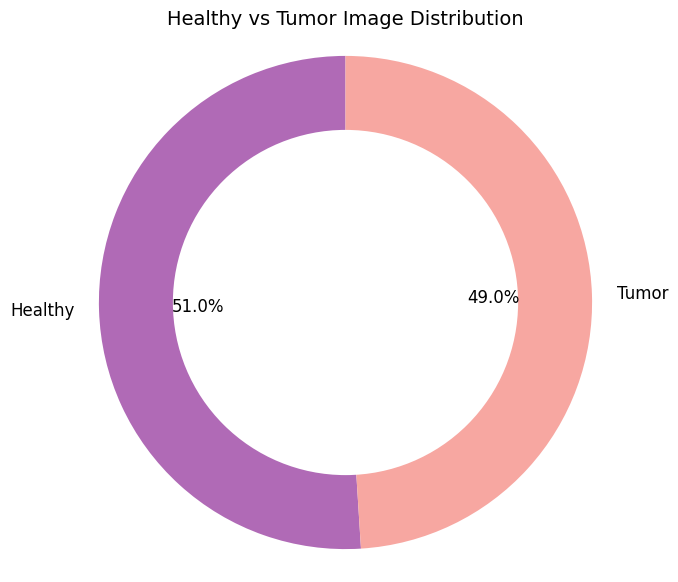

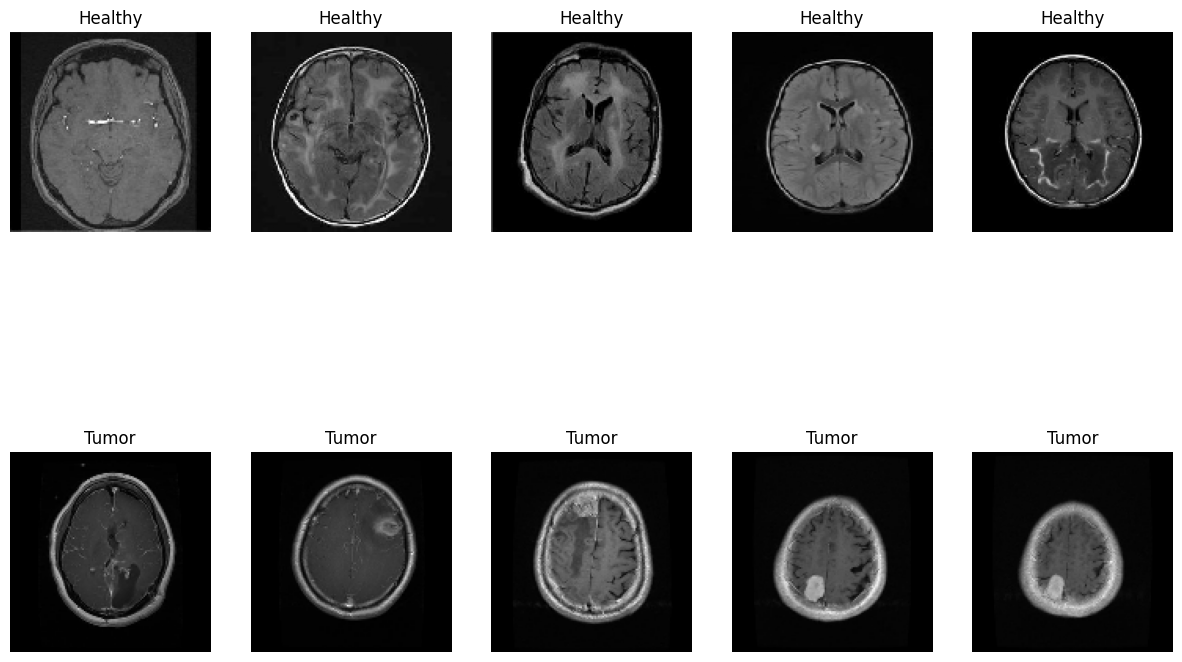

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Custom color palette resembling brain images
custom_colors = ['#B06AB6', '#F7A7A1']  # Light purple and pink

# EDA: Visualizing distribution of data with custom color bar plot
sns.countplot(x=y, palette=custom_colors)
plt.title('Distribution of Healthy and Tumor Images', fontsize=14)
plt.xticks([0, 1], ['Healthy', 'Tumor'], fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# EDA: Visualizing distribution of data using a donut chart with custom colors
labels = ['Healthy', 'Tumor']
sizes = [len(healthy_labels), len(tumor_labels)]
pie_colors = ['#B06AB6', '#F7A7A1']  # Light purple and pink

plt.figure(figsize=(7, 7))
# Create a pie chart with a hole (donut)
plt.pie(sizes, labels=labels, colors=pie_colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
centre_circle = plt.Circle((0, 0), 0.70, fc='white')  # Add a white circle in the center
fig = plt.gcf()
fig.gca().add_artist(centre_circle)  # Add the circle to the pie chart
plt.title('Healthy vs Tumor Image Distribution', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Visualize a few sample images from the dataset, showing both healthy and tumor images
def show_sample_images(X, y, num_samples=10):
    plt.figure(figsize=(15, 10))
    healthy_count = 0
    tumor_count = 0
    for i in range(num_samples):
        plt.subplot(2, num_samples // 2, i + 1)
        if healthy_count < num_samples // 2:
            plt.imshow(X[healthy_count])
            plt.title('Healthy', fontsize=12)
            healthy_count += 1
        else:
            plt.imshow(X[len(healthy_images) + tumor_count])
            plt.title('Tumor', fontsize=12)
            tumor_count += 1
        plt.axis('off')
    plt.show()

# Show sample images of both healthy and tumor
show_sample_images(X, y)

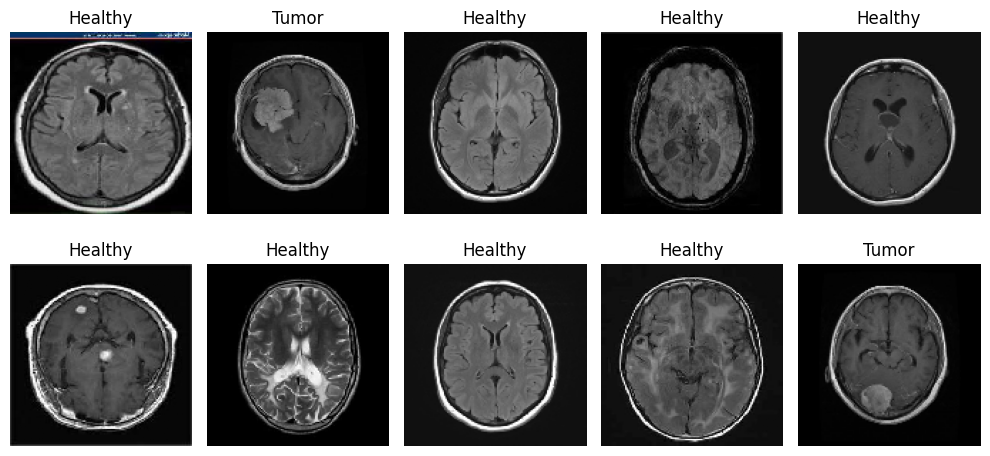

In [28]:
import matplotlib.pyplot as plt

def plot_sample_images(X, y, num_samples=5):
    """Plot sample images from the dataset."""
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(X[i])
        plt.title('Healthy' if y[i] == 0 else 'Tumor')
        plt.axis('off')
    for i in range(num_samples):
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(X[i + num_samples])
        plt.title('Healthy' if y[i + num_samples] == 0 else 'Tumor')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot sample images
plot_sample_images(X_train, y_train, num_samples=5)

In [29]:
# Data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=16)

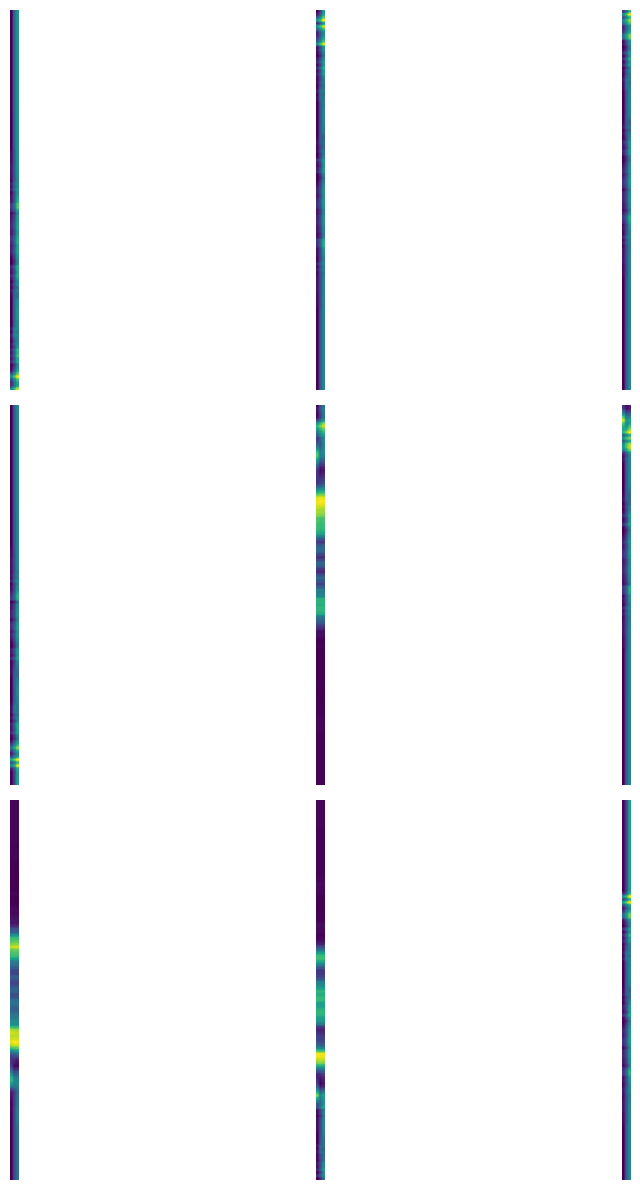

In [30]:
# Sample image for augmentation visualization
sample_image = X_train[0].reshape((1, ) + X_train[0].shape)  # Reshape for flow method

# Create a generator for the sample image
augmented_images = train_datagen.flow(sample_image)

# Plot augmented images
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = next(augmented_images)[0][0]  # Get the first image from the batch
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

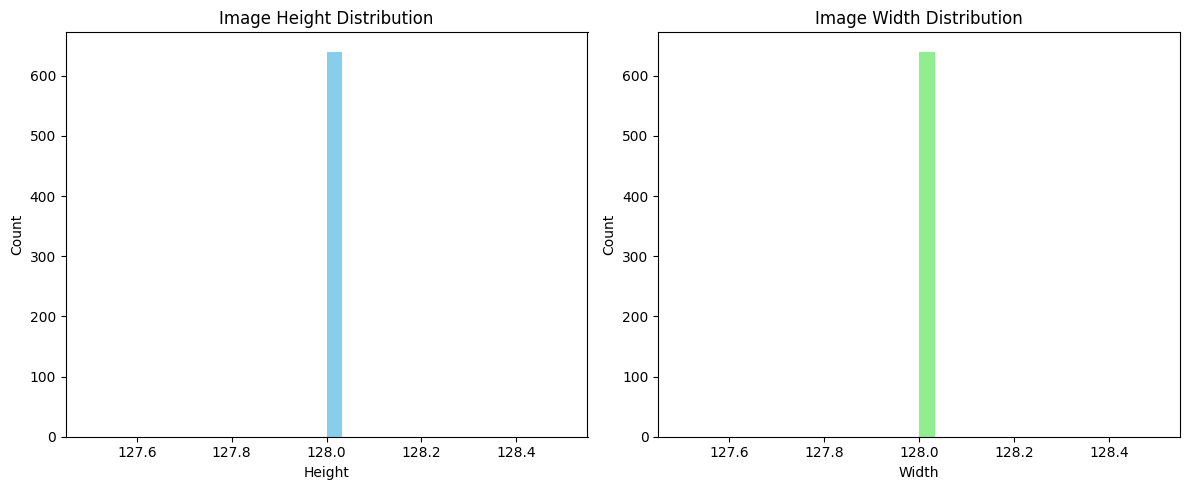

In [31]:
# Get dimensions of images
heights = [image.shape[0] for image in X_train]
widths = [image.shape[1] for image in X_train]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(heights, bins=30, color='skyblue')
plt.title('Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(widths, bins=30, color='lightgreen')
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [32]:
# Function to build a transfer learning model with fine-tuning capability
def build_transfer_model_fine_tune(base_model, input_shape):
    base_model.trainable = False  # Freeze all layers initially
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    return model

In [33]:

####################################
# Building Transfer Learning Models #
#####################################


# Fine-tune function to unfreeze layers and retrain the model
def fine_tune_model(model, base_model, fine_tune_at):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False  # Keep earlier layers frozen
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
#######################################################
# Defining Pre-trained Models and Fine-Tuning Layers
##########################################################


# Adjust input shape
input_shape = (128, 128, 3)

# Define pre-trained base models and names (keeping InceptionV3, Xception, DenseNet201, MobileNetV2)
pretrained_models = {
    "InceptionV3": tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape),
    "Xception": tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=input_shape),
    "DenseNet201": tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape),
    "MobileNetV2": tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape),
}

# Use a smaller batch size
train_generator = train_datagen.flow(X_train, y_train, batch_size=16)  # Adjust batch size


In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint

# List of model names to train
model_names = ['InceptionV3', 'Xception', 'DenseNet201', 'MobileNetV2']

# Define the path to save the best model (overwrites previous models)
checkpoint_path = "best_final_model.keras"

# ModelCheckpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',   # Change to 'val_accuracy' if needed
    save_best_only=True,
    mode='min',           # Since we aim to minimize val_loss
    verbose=1
)

for name in model_names:
    base_model = pretrained_models[name]
    
    # Step 1: Build the transfer learning model (initial training)
    print(f"Training {name}...")
    transfer_model = build_transfer_model_fine_tune(base_model, input_shape)
    
    # Compile and train the model
    transfer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = transfer_model.fit(
        train_generator, 
        epochs=10, 
        validation_data=(X_test, y_test),
        callbacks=[checkpoint]  # Pass ModelCheckpoint as a callback
    )

print(f"✅ Best model saved as {checkpoint_path}")


Training InceptionV3...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7702 - loss: 0.7052
Epoch 1: val_loss improved from inf to 0.22951, saving model to best_final_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.7723 - loss: 0.7005 - val_accuracy: 0.9563 - val_loss: 0.2295
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9306 - loss: 0.3206
Epoch 2: val_loss improved from 0.22951 to 0.07528, saving model to best_final_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.9307 - loss: 0.3197 - val_accuracy: 0.9875 - val_loss: 0.0753
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9621 - loss: 0.1526
Epoch 3: val_loss improved from 0.07528 to 0.06145, saving model to best_final_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.9622 - loss: 0.1525 - val_accuracy: 0.9937 - val_loss: 0.0614
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9452 - loss: 0.2138
Epoch 4: va

In [40]:
#############################
# Fine-Tuning the Model
################################

# Define pre-trained base models and names (excluding VGG19 and ResNet50)
pretrained_models = {
    "InceptionV3": tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape),
    "Xception": tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=input_shape),
    "DenseNet201": tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape),
    "MobileNetV2": tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape),
}

fine_tune_at_layers = {
    "InceptionV3": 249,
    "Xception": 132,
    "DenseNet201": 705,
    "MobileNetV2": 100,
}

# Training and Evaluation Process
model_names = ['InceptionV3', 'Xception', 'DenseNet201', 'MobileNetV2']
for name in model_names:
    base_model = pretrained_models[name]
    
    # Step 1: Build the transfer learning model (initial training)
    print(f"Training {name}...")
    transfer_model = build_transfer_model_fine_tune(base_model, input_shape)
    
    # Compile and train the top layers
    transfer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = transfer_model.fit(train_generator, epochs=10, validation_data=(X_test, y_test))
    
    # Step 2: Fine-tune the model
    print(f"Fine-tuning {name}...")
    transfer_model = fine_tune_model(transfer_model, base_model, fine_tune_at_layers[name])
    
    # Fine-tune for additional 10 epochs
    fine_tune_history = transfer_model.fit(train_generator, epochs=10, validation_data=(X_test, y_test))

Training InceptionV3...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - accuracy: 0.6470 - loss: 3.7199 - val_accuracy: 0.7375 - val_loss: 1.8930
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.8188 - loss: 1.1621 - val_accuracy: 0.8000 - val_loss: 0.4473
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.8323 - loss: 0.4418 - val_accuracy: 0.8125 - val_loss: 0.3889
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.7863 - loss: 0.4572 - val_accuracy: 0.9062 - val_loss: 0.1678
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.8365 - loss: 0.3411 - val_accuracy: 0.9125 - val_loss: 0.1964
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.8679 - loss: 0.3923 - val_accuracy: 0.9125 - val_loss: 0.1781
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9054 - loss: 0.2954 - val_accuracy: 0.9375 - val_loss: 0.1729
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9135 - loss: 

Training InceptionV3...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.8130 - loss: 0.5871 - val_accuracy: 0.9500 - val_loss: 0.2170
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.8939 - loss: 0.5586 - val_accuracy: 0.8875 - val_loss: 0.4667
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9083 - loss: 0.3666 - val_accuracy: 0.9688 - val_loss: 0.1347
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9211 - loss: 0.2310 - val_accuracy: 0.9688 - val_loss: 0.1285
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9318 - loss: 0.1971 - val_accuracy: 0.9625 - val_loss: 0.1426
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9360 - loss: 0.2590 - val_accuracy: 0.9625 - val_loss: 0.1122
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.9308 - loss: 0.1934 - val_accuracy: 0.9688 - val_loss: 0.1067
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9334 - loss: 

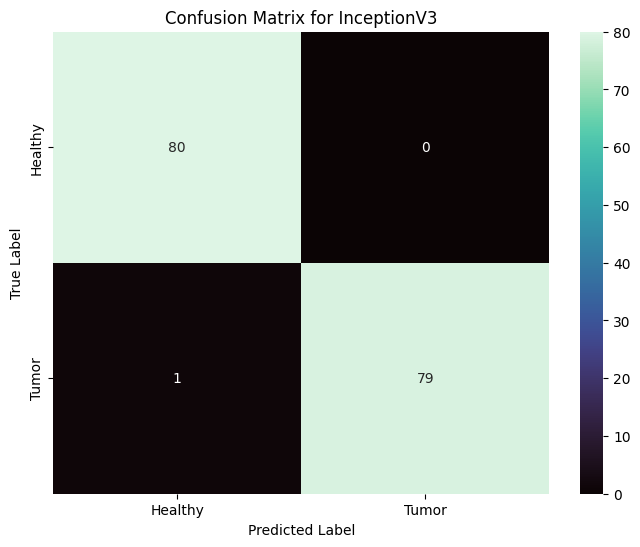

Training Xception...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 378ms/step - accuracy: 0.7500 - loss: 2.7606 - val_accuracy: 0.9000 - val_loss: 0.4446
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - accuracy: 0.8690 - loss: 0.6866 - val_accuracy: 0.9563 - val_loss: 0.2234
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - accuracy: 0.8743 - loss: 0.5111 - val_accuracy: 0.9187 - val_loss: 0.2017
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - accuracy: 0.8950 - loss: 0.2436 - val_accuracy: 0.9563 - val_loss: 0.1279
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 357ms/step - accuracy: 0.8773 - loss: 0.2898 - val_accuracy: 0.9187 - val_loss: 0.2150
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 355ms/step - accuracy: 0.9171 - loss: 0.2383 - val_accuracy: 0.9438 - val_loss: 0.1640
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 340ms/step - accuracy: 0.9247 - loss: 0.2062 - val_accuracy: 0.9438 - val_loss: 0.1608
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step - accuracy: 0.9309 - lo

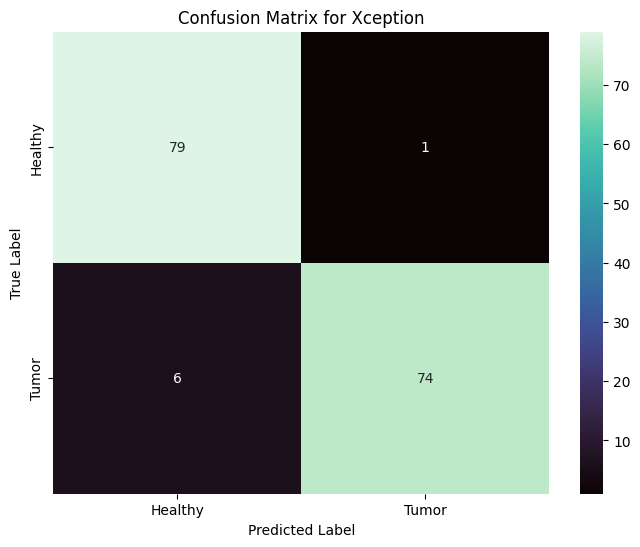

Training DenseNet201...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 692ms/step - accuracy: 0.7317 - loss: 2.7524 - val_accuracy: 0.9375 - val_loss: 0.5155
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 559ms/step - accuracy: 0.9228 - loss: 0.4651 - val_accuracy: 0.9625 - val_loss: 0.1980
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 571ms/step - accuracy: 0.8897 - loss: 0.4172 - val_accuracy: 0.9500 - val_loss: 0.1087
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 634ms/step - accuracy: 0.9543 - loss: 0.1617 - val_accuracy: 0.9500 - val_loss: 0.1946
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 614ms/step - accuracy: 0.9174 - loss: 0.2562 - val_accuracy: 0.9688 - val_loss: 0.1057
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 554ms/step - accuracy: 0.9577 - loss: 0.1154 - val_accuracy: 0.9750 - val_loss: 0.0821
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 550ms/step - accuracy: 0.9560 - loss: 0.1648 - val_accuracy: 0.9812 - val_loss: 0.0587
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 517ms/step - accuracy: 0.9697 -

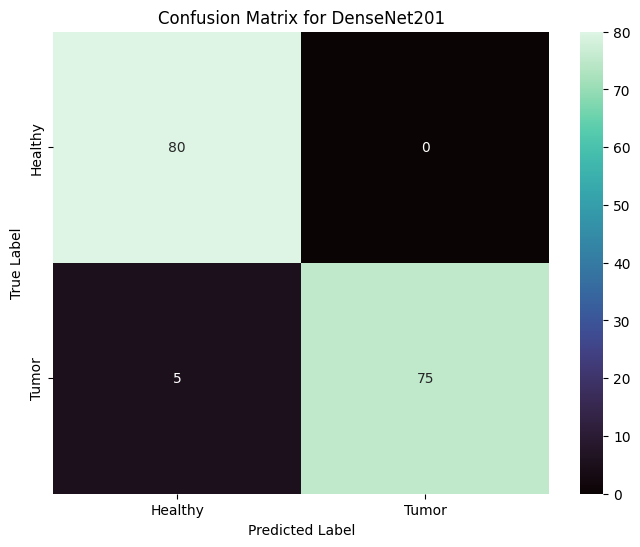

Training MobileNetV2...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.7676 - loss: 1.8061 - val_accuracy: 0.9500 - val_loss: 0.4899
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8964 - loss: 0.6972 - val_accuracy: 0.9375 - val_loss: 0.3378
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.9251 - loss: 0.4042 - val_accuracy: 0.9312 - val_loss: 0.2891
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.9288 - loss: 0.2786 - val_accuracy: 0.9812 - val_loss: 0.0919
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.9349 - loss: 0.2383 - val_accuracy: 0.9688 - val_loss: 0.0832
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.9593 - loss: 0.1216 - val_accuracy: 0.9812 - val_loss: 0.0787
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.9724 - loss: 0.1098 - val_accuracy: 0.9812 - val_loss: 0.0897
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.9522 - loss: 

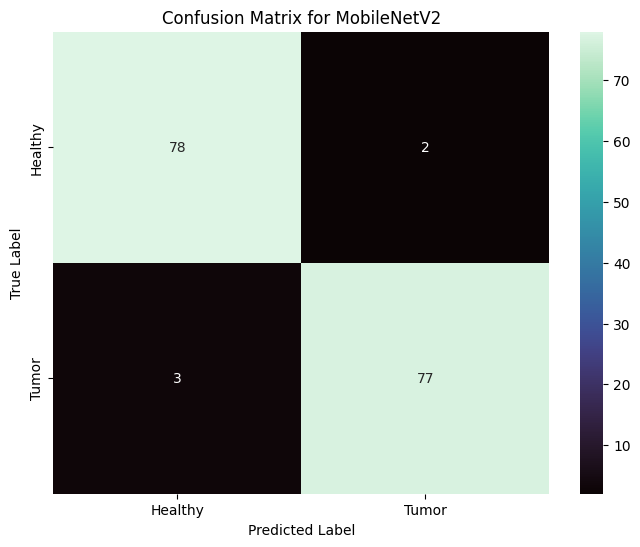

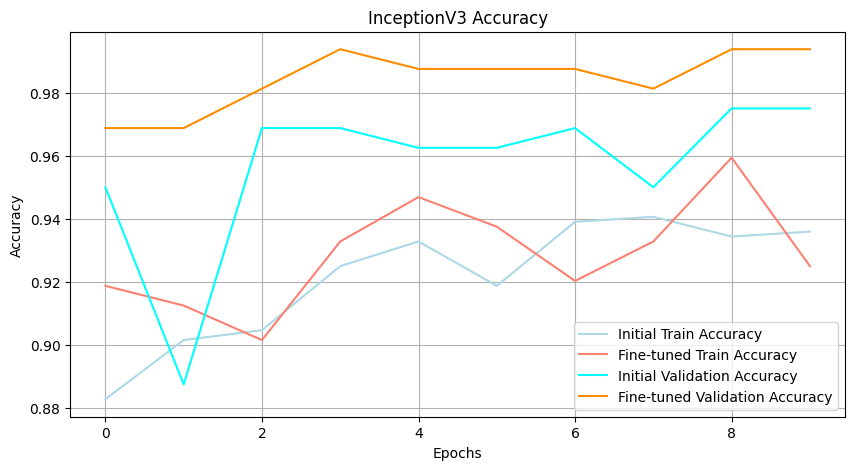

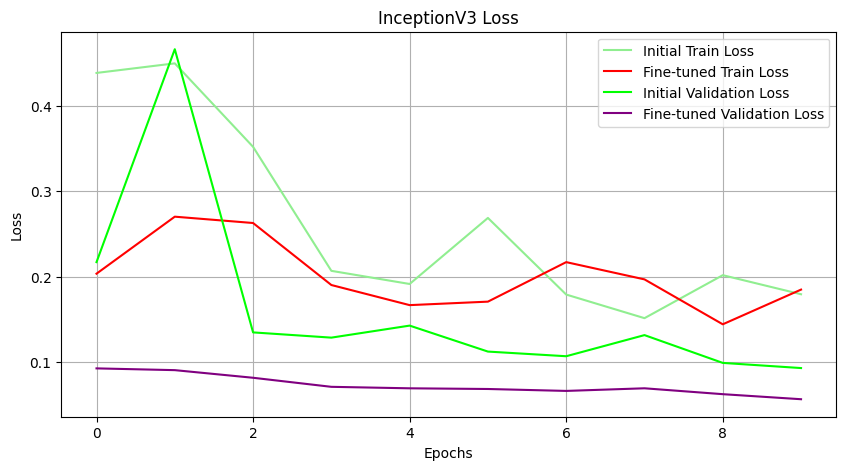

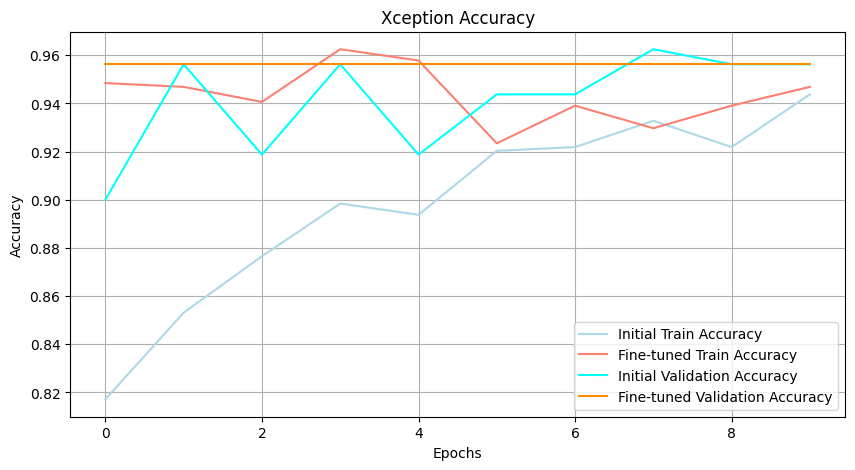

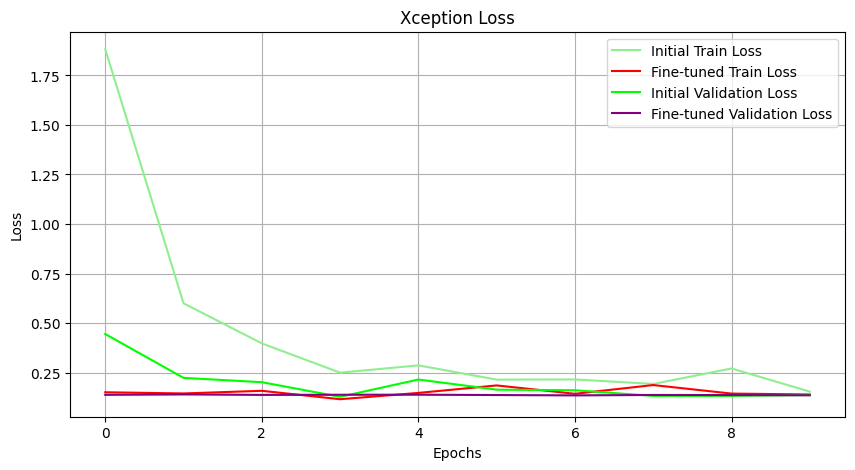

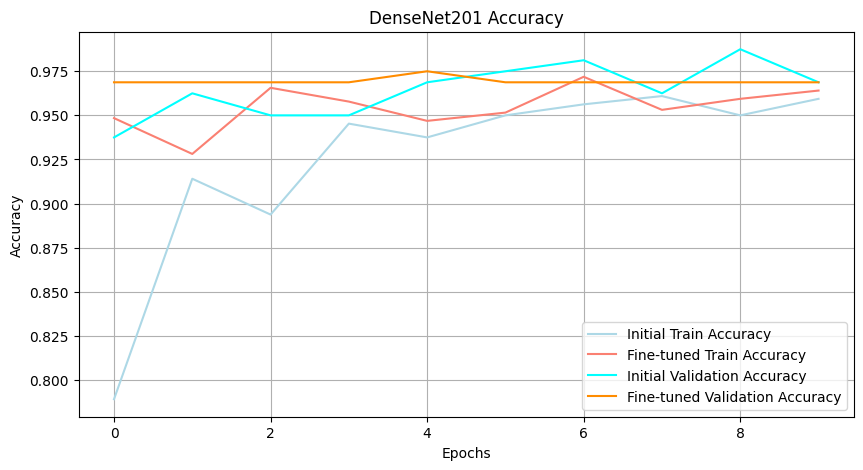

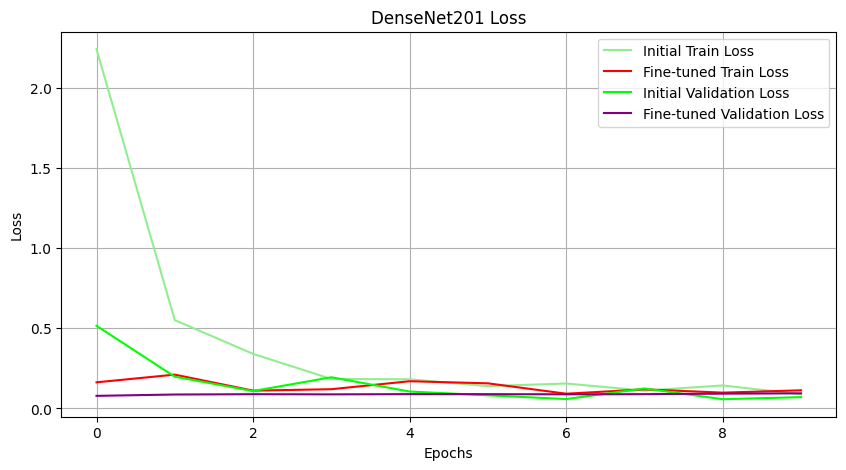

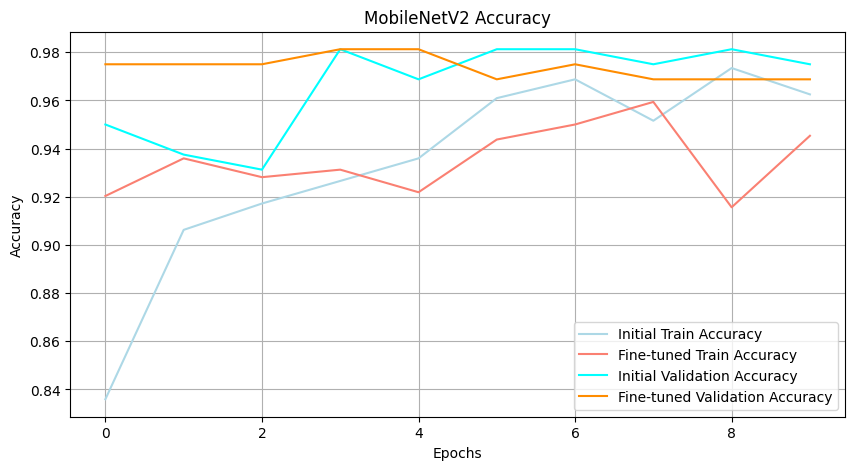

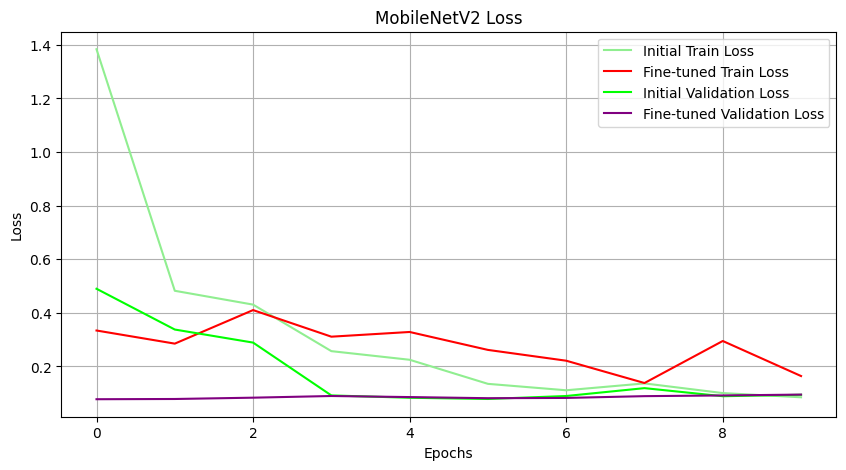

In [41]:
##################################
# Evaluation and Visualization
###################################

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Lists to store the history of metrics for all models
all_history = []
all_fine_tune_history = []
model_names = ['InceptionV3', 'Xception', 'DenseNet201', 'MobileNetV2']

# Training and Evaluation Process
for name in model_names:
    base_model = pretrained_models[name]
    
    # Step 1: Build the transfer learning model (initial training)
    print(f"Training {name}...")
    transfer_model = build_transfer_model_fine_tune(base_model, input_shape)
    
    # Compile and train the top layers
    transfer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = transfer_model.fit(train_generator, epochs=10, validation_data=(X_test, y_test))
    
    # Step 2: Fine-tune the model
    print(f"Fine-tuning {name}...")
    transfer_model = fine_tune_model(transfer_model, base_model, fine_tune_at_layers[name])
    
    # Fine-tune for additional 10 epochs
    fine_tune_history = transfer_model.fit(train_generator, epochs=10, validation_data=(X_test, y_test))
    
    # Store the histories
    all_history.append(history)
    all_fine_tune_history.append(fine_tune_history)
    
    # Evaluation
    y_pred = transfer_model.predict(X_test)
    y_pred_labels = (y_pred > 0.5).astype(int)
    
    # Print classification report
    print(f"Classification report for {name}:")
    print(classification_report(y_test, y_pred_labels))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_labels)

    # Confusion Matrix Visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='mako', cbar=True,
                xticklabels=['Healthy', 'Tumor'], yticklabels=['Healthy', 'Tumor'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# After all models have been trained and evaluated, plot the accuracies and losses
for i, name in enumerate(model_names):
    # Accuracy Plot
    plt.figure(figsize=(10, 5))
    plt.plot(all_history[i].history['accuracy'], label='Initial Train Accuracy', color='lightblue')
    plt.plot(all_fine_tune_history[i].history['accuracy'], label='Fine-tuned Train Accuracy', color='salmon')
    plt.plot(all_history[i].history['val_accuracy'], label='Initial Validation Accuracy', color='cyan')
    plt.plot(all_fine_tune_history[i].history['val_accuracy'], label='Fine-tuned Validation Accuracy', color='darkorange')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(10, 5))
    plt.plot(all_history[i].history['loss'], label='Initial Train Loss', color='lightgreen')
    plt.plot(all_fine_tune_history[i].history['loss'], label='Fine-tuned Train Loss', color='red')
    plt.plot(all_history[i].history['val_loss'], label='Initial Validation Loss', color='lime')
    plt.plot(all_fine_tune_history[i].history['val_loss'], label='Fine-tuned Validation Loss', color='purple')
    plt.title(f'{name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [42]:
############################################
#  Aggregate Performance Metrics
##########################################

import pandas as pd

# Lists to store model metrics
metrics_summary = []

# Training and Evaluation Process
for name in model_names:
    base_model = pretrained_models[name]
    
    # Step 1: Build the transfer learning model (initial training)
    print(f"Training {name}...")
    transfer_model = build_transfer_model_fine_tune(base_model, input_shape)
    
    # Compile and train the top layers
    transfer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = transfer_model.fit(train_generator, epochs=10, validation_data=(X_test, y_test))
    
    # Step 2: Fine-tune the model
    print(f"Fine-tuning {name}...")
    transfer_model = fine_tune_model(transfer_model, base_model, fine_tune_at_layers[name])
    
    # Fine-tune for additional 10 epochs
    fine_tune_history = transfer_model.fit(train_generator, epochs=10, validation_data=(X_test, y_test))
    
    # Store metrics
    final_train_accuracy = fine_tune_history.history['accuracy'][-1]
    final_val_accuracy = fine_tune_history.history['val_accuracy'][-1]
    final_train_loss = fine_tune_history.history['loss'][-1]
    final_val_loss = fine_tune_history.history['val_loss'][-1]
    
    # Append metrics to summary
    metrics_summary.append({
        'Model': name,
        'Final Train Accuracy': final_train_accuracy,
        'Final Validation Accuracy': final_val_accuracy,
        'Final Train Loss': final_train_loss,
        'Final Validation Loss': final_val_loss
    })

# Convert to DataFrame for better visualization
metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df)

Training InceptionV3...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 205ms/step - accuracy: 0.7953 - loss: 0.6640 - val_accuracy: 0.9500 - val_loss: 0.1452
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.9415 - loss: 0.2104 - val_accuracy: 0.9750 - val_loss: 0.0874
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.9699 - loss: 0.1200 - val_accuracy: 0.9187 - val_loss: 0.3486
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.8842 - loss: 0.3955 - val_accuracy: 0.9500 - val_loss: 0.1378
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.9446 - loss: 0.2068 - val_accuracy: 0.9812 - val_loss: 0.0745
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.9398 - loss: 0.1513 - val_accuracy: 0.9750 - val_loss: 0.0886
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.9359 - loss: 0.1530 - val_accuracy: 0.9750 - val_loss: 0.0804
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.9425 - loss: 

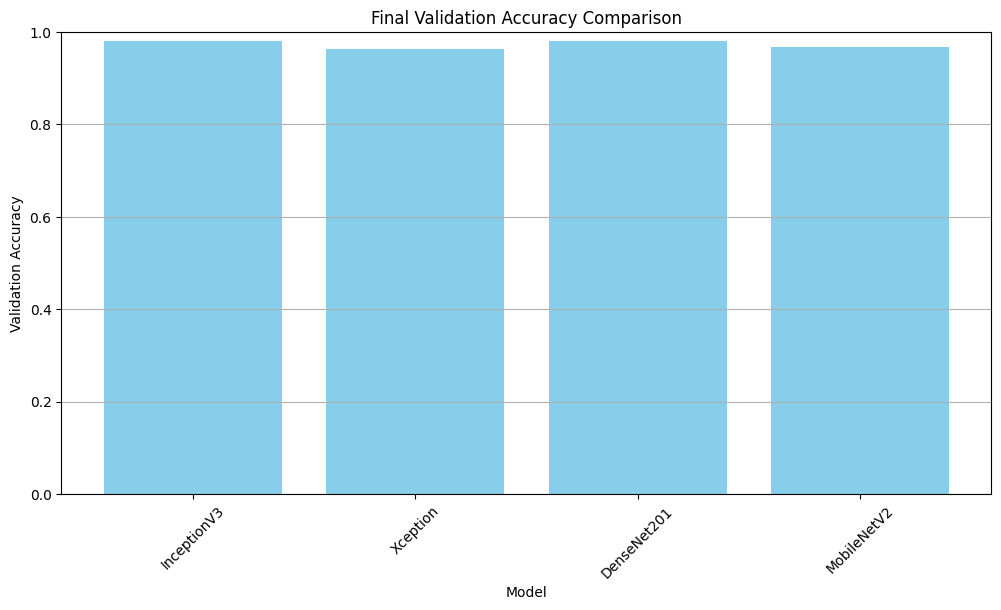

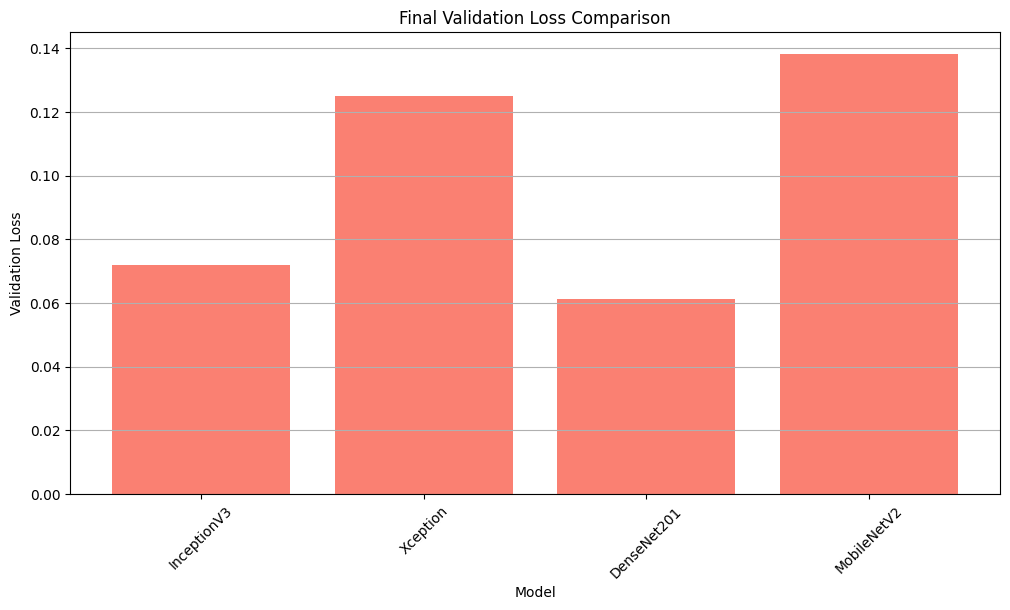

In [43]:
#################################
# Visualize Comparisons
###############################



# Plotting Accuracy Comparison
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Model'], metrics_df['Final Validation Accuracy'], color='skyblue')
plt.title('Final Validation Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.xticks(rotation=45)
plt.ylim([0, 1])
plt.grid(axis='y')
plt.show()

# Plotting Loss Comparison
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Model'], metrics_df['Final Validation Loss'], color='salmon')
plt.title('Final Validation Loss Comparison')
plt.xlabel('Model')
plt.ylabel('Validation Loss')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


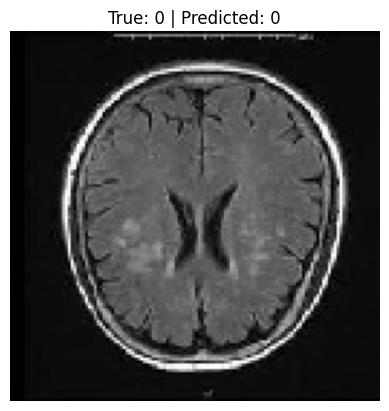

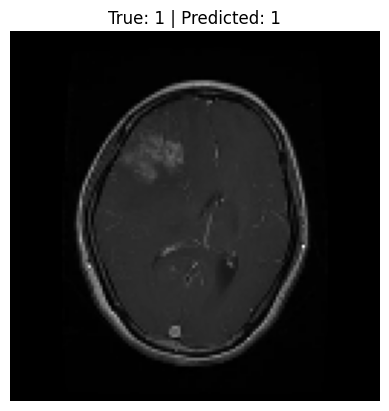

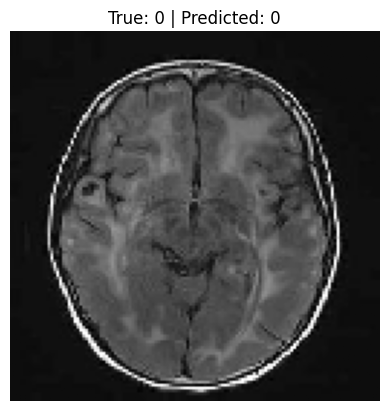

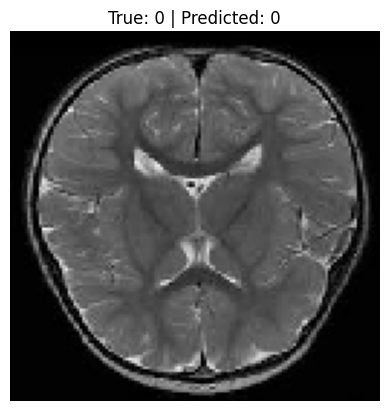

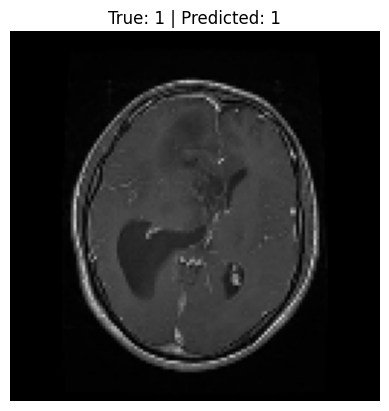

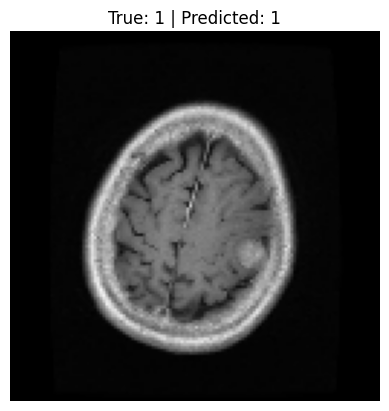

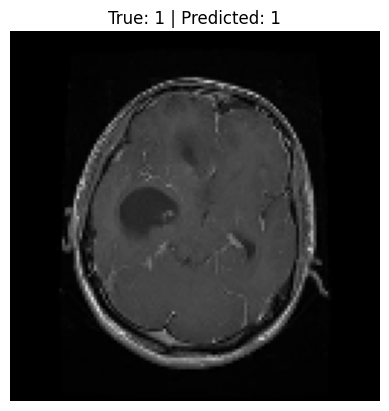

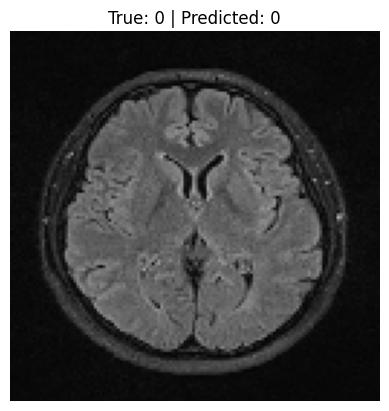

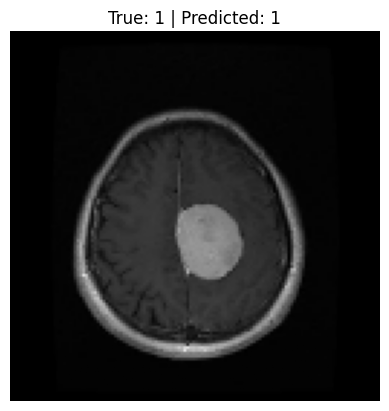

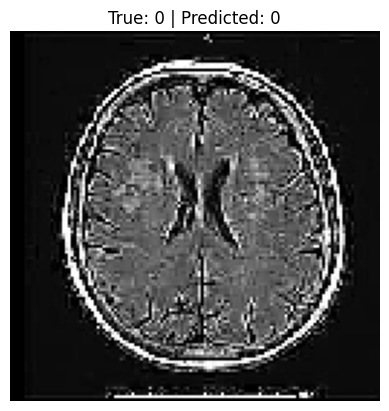

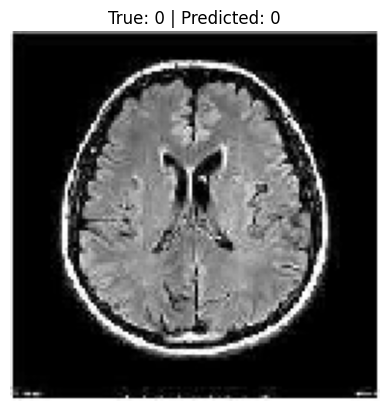

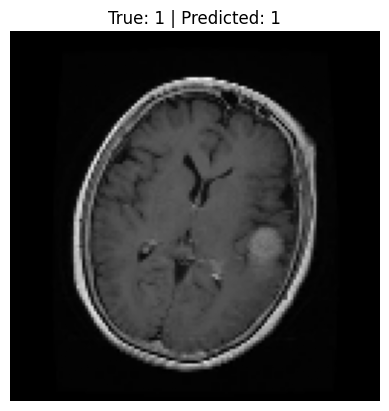

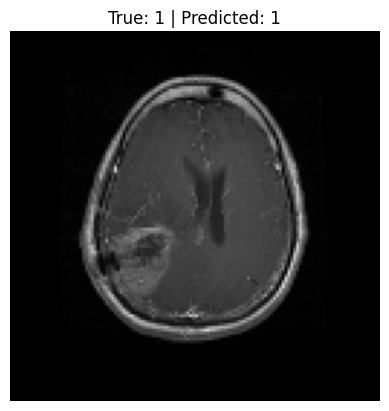

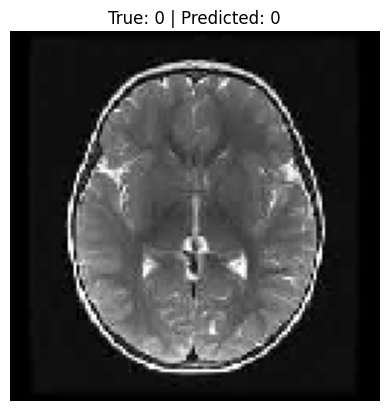

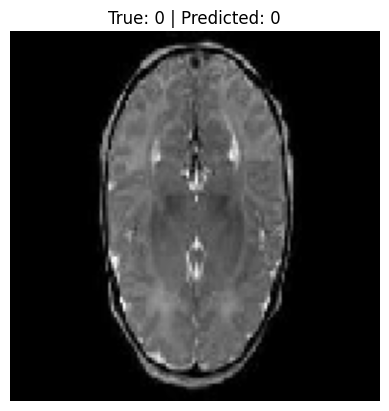

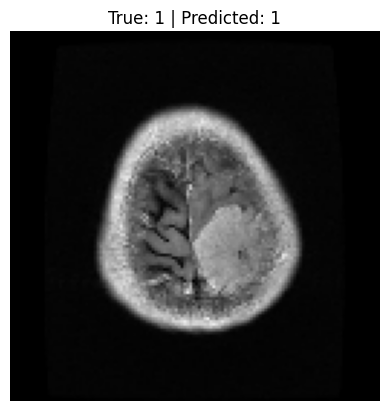

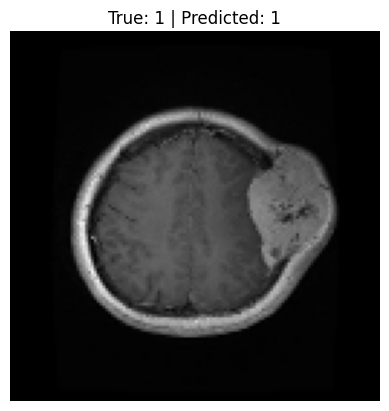

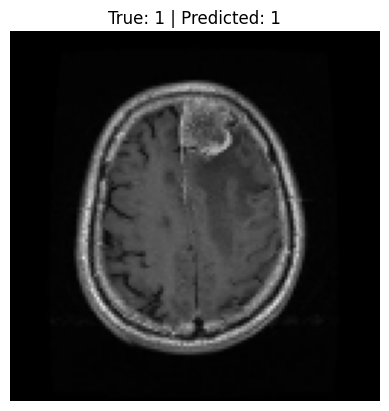

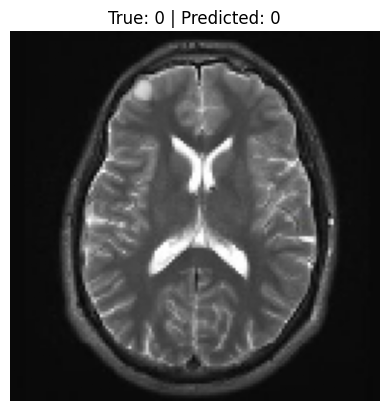

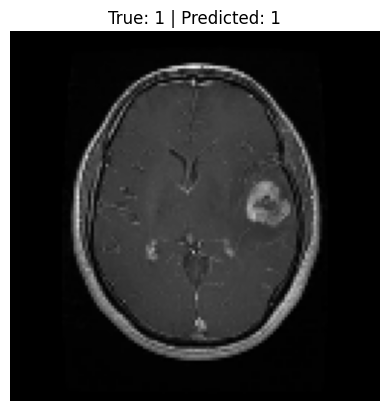

In [54]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt

# Load the best model
model = tf.keras.models.load_model("best_final_model.keras")

# Select 20 random images from the test dataset
num_samples = 20
random_indices = random.sample(range(len(X_test)), num_samples)
X_sample = X_test[random_indices]  # Selected images
y_true = y_test[random_indices]    # True labels

# Make predictions
y_pred_probs = model.predict(X_sample)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Display results
for i in range(num_samples):
    plt.imshow(X_sample[i])
    plt.axis('off')
    plt.title(f"True: {y_true[i]} | Predicted: {y_pred[i][0]}")
    plt.show()  